In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask

from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import metpy.calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2023-09-19 22:31:46,709 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-wj8vre0z', purging
2023-09-19 22:31:46,715 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-oqhmwug3', purging
2023-09-19 22:31:46,719 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-vs58jj63', purging
2023-09-19 22:31:46,723 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-d2c4muh3', purging
2023-09-19 22:31:46,728 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-7a3q2ayy', purging
2023-09-19 22:31:46,733 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/dask-worker-space/worker-zc4dps36', purging
2023

In [2]:
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


## Load wind data

_plevel winds_

In [3]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d_ua = 'ctl_daily_ua_plev_2022'
glob_pattern_3d_va = 'ctl_daily_va_plev_2022'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/3d/wind_plev')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon_ua = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d_ua}*.nc')])[:]
file_icon_va = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d_va}*.nc')])[:]

In [4]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d_ua = 'def_daily_ua_plev_2022'
glob_pattern_3d_va = 'def_daily_va_plev_2022'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/3d/wind_plev')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_ua = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d_ua}*.nc')])[:]
file_def_va = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d_va}*.nc')])[:]

In [5]:
times = ['2022-01-01','2022-12-31']
var_ua = 'ua'
var_va = 'va'
time_mean = '1MS'

ua_ctl_land = Tools.time_mean_model(file_icon_ua,times,time_mean,var_ua,[-60,20],[-100,-20],'trop')
ua_def_land = Tools.time_mean_model(file_def_ua,times,time_mean,var_ua,[-60,20],[-100,-20],'trop')

va_ctl_land = Tools.time_mean_model(file_icon_va,times,time_mean,var_va,[-60,20],[-100,-20],'trop')
va_def_land = Tools.time_mean_model(file_def_va,times,time_mean,var_va,[-60,20],[-100,-20],'trop')

In [6]:
ua_ctl_month = ua_ctl_land.groupby('time.month').mean('time')
ua_def_month = ua_def_land.groupby('time.month').mean('time')

va_ctl_month = va_ctl_land.groupby('time.month').mean('time')
va_def_month = va_def_land.groupby('time.month').mean('time')

In [7]:
xarray_names = ['ua_ctl_month','ua_def_month','va_ctl_month','va_def_month']
plevel = ['100000', '70000']

for name in xarray_names:
    xarray_data = globals()[name]
    for plev in plevel:
        xarray_data_wet = xarray_data.sel(plev=plev).where(xarray_data.month.isin([1,2,12]), drop=True).mean("month")
        xarray_data_dry = xarray_data.sel(plev=plev).where(xarray_data.month.isin([7,8,9]), drop=True).mean("month")
        
        new_name_wet = name + '_' + plev + '_wet'
        new_name_dry = name + '_' + plev + '_dry'
        
        globals()[new_name_wet] = xarray_data_wet
        globals()[new_name_dry] = xarray_data_dry

_surface wind_

In [9]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_uas = 'ctl_6hrly_uas_2022'
glob_pattern_vas = 'ctl_6hrly_vas_2022'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/3d/wind')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon_uas = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_uas}*.nc')])[:]
file_icon_vas = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_vas}*.nc')])[:]

In [10]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_uas = 'def_6hrly_uas_2022'
glob_pattern_vas = 'def_6hrly_vas_2022'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/3d/wind')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_uas = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_uas}*.nc')])[:]
file_def_vas = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_vas}*.nc')])[:]

In [11]:
times = ['2022-01-01','2022-12-31']
var_ua = 'uas'
var_va = 'vas'
time_mean = '1MS'

uas_ctl_land = Tools.time_mean_model(file_icon_uas,times,time_mean,var_ua,[-60,20],[-100,-20],'trop')
uas_def_land = Tools.time_mean_model(file_def_uas,times,time_mean,var_ua,[-60,20],[-100,-20],'trop')

vas_ctl_land = Tools.time_mean_model(file_icon_vas,times,time_mean,var_va,[-60,20],[-100,-20],'trop')
vas_def_land = Tools.time_mean_model(file_def_vas,times,time_mean,var_va,[-60,20],[-100,-20],'trop')

In [12]:
uas_ctl_month = uas_ctl_land.groupby('time.month').mean('time')
uas_def_month = uas_def_land.groupby('time.month').mean('time')

vas_ctl_month = vas_ctl_land.groupby('time.month').mean('time')
vas_def_month = vas_def_land.groupby('time.month').mean('time')

In [13]:
xarray_names = ['uas_ctl_month','uas_def_month','vas_ctl_month','vas_def_month']

for name in xarray_names:
    xarray_data = globals()[name]
    
    xarray_data_wet = xarray_data.sel(height=10).where(xarray_data.month.isin([1,2,12]), drop=True).mean("month")
    xarray_data_dry = xarray_data.sel(height=10).where(xarray_data.month.isin([7,8,9]), drop=True).mean("month")
        
    new_name_wet = name + '_sfc' + '_wet'
    new_name_dry = name + '_sfc' + '_dry'
        
    globals()[new_name_wet] = xarray_data_wet
    globals()[new_name_dry] = xarray_data_dry

In [79]:
uas_ctl_month_sfc_wet

<xarray.DataArray 'uas' (lat: 800, lon: 800)>
array([[ 7.019529  ,  7.016562  ,  7.00865   , ...,  5.539308  ,
         5.540771  ,  5.53808   ],
       [ 7.026941  ,  7.030033  ,  7.034162  , ...,  5.581103  ,
         5.580316  ,  5.5734496 ],
       [ 7.0321274 ,  7.029777  ,  7.026584  , ...,  5.636378  ,
         5.6334786 ,  5.6330953 ],
       ...,
       [ 0.2110322 , -0.12892492,  0.0840948 , ..., -5.0556855 ,
        -5.023213  , -4.964337  ],
       [-0.2932453 , -0.35164312,  0.11896175, ..., -5.073725  ,
        -5.0479336 , -4.9989796 ],
       [ 0.05369945,  0.059609  ,  0.36262536, ..., -5.0815473 ,
        -5.051209  , -5.0114694 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -99.95 -99.85 -99.75 -99.65 ... -20.25 -20.15 -20.05
  * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 19.75 19.85 19.95
    height   float64 10.0

_since converted one has same time axis for all different files, time needs to be changed into correct one_

In [6]:
# Reference data
glob_pattern_3d1 = 'atm_3d_1_ml_2021'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/m300948/nextgems_cycle2_2/experiments/DEF100/work')
ctl_2d_list = []
files = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*.nc')],reverse=True)[:]

for f in files:
    if str(f)[-19:-3] not in [str(t)[-19:-3] for t in ctl_2d_list]:

#if str(f)[-19:-3] for f in files not in str(t)[-19:-3] for t in ctl_2d_list:
#        print(str(f)[-19:-3])
        ctl_2d_list.append(str(f))

filespressure = sorted(ctl_2d_list)

## Load GPH data

In [8]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'ctl_daily_zg_plev_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/gph/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon_pp = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d1}*.nc')])[:]

In [9]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'def_daily_zg_plev_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/gph/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_pp = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d1}*.nc')])[:]

In [10]:
times = ['2022-01-01','2022-12-31']
var = 'zg'
time_mean = '1MS'

zg_ctl_land = Tools.time_mean_model(file_icon_pp,times,time_mean,var,[-60,20],[-100,-20],'trop')
zg_def_land = Tools.time_mean_model(file_def_pp,times,time_mean,var,[-60,20],[-100,-20],'trop')

In [11]:
# groupby: groupping by month throughout the whole time period
zg_ctl_month = zg_ctl_land.groupby('time.month').mean('time')
zg_def_month = zg_def_land.groupby('time.month').mean('time')

In [12]:
xarray_names = ['zg_ctl_month','zg_def_month']
plevel = ['100000', '70000']

for name in xarray_names:
    xarray_data = globals()[name]
    for plev in plevel:
        xarray_data_wet = xarray_data.sel(plev=plev).where(xarray_data.month.isin([1,2,12]), drop=True).mean("month")
        xarray_data_dry = xarray_data.sel(plev=plev).where(xarray_data.month.isin([7,8,9]), drop=True).mean("month")
        
        new_name_wet = name + '_' + plev + '_wet'
        new_name_dry = name + '_' + plev + '_dry'
        
        globals()[new_name_wet] = xarray_data_wet
        globals()[new_name_dry] = xarray_data_dry

## Load Fluxes data

In [3]:
glob_pattern_hfls = 'ctl_6hrly_hfls_'
glob_pattern_hfss = 'ctl_6hrly_hfss_'

data_path_hfls = Path('/scratch/m/m300948/test_04/hfls')
data_path_hfss = Path('/scratch/m/m300948/test_04/flux/hfss')

## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_ctl_hfls = sorted([str(f) for f in data_path_hfls.rglob(f'{glob_pattern_hfls}*.nc')])[:]
file_ctl_hfss = sorted([str(f) for f in data_path_hfss.rglob(f'{glob_pattern_hfss}*.nc')])[:]

In [4]:
glob_pattern_hfls = 'def_6hrly_hfls_'
glob_pattern_hfss = 'def_6hrly_hfss_'

data_path_hfls = Path('/scratch/m/m300948/def_100/hfls')
data_path_hfss = Path('/scratch/m/m300948/def_100/hfls')

## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_hfls = sorted([str(f) for f in data_path_hfls.rglob(f'{glob_pattern_hfls}*.nc')])[:]
file_def_hfss = sorted([str(f) for f in data_path_hfss.rglob(f'{glob_pattern_hfss}*.nc')])[:]

In [5]:
times = ['2020-01-01','2022-12-31']
var_hfls = 'hfls'
var_hfss = 'hfss'
time_mean = '1MS'

hfls_ctl_land = Tools.time_mean_model(file_ctl_hfls,times,time_mean,var_hfls,[-60,20],[-100,-20],'trop')
hfss_ctl_land = Tools.time_mean_model(file_ctl_hfss,times,time_mean,var_hfss,[-60,20],[-100,-20],'trop')

In [6]:
hfls_def_land = Tools.time_mean_model(file_def_hfls,times,time_mean,var_hfls,[-60,20],[-100,-20],'trop')
hfss_def_land = Tools.time_mean_model(file_def_hfss,times,time_mean,var_hfss,[-60,20],[-100,-20],'trop')

In [7]:
# groupby: groupping by month throughout the whole time period
hfls_ctl_month = hfls_ctl_land.groupby('time.month').mean('time')
hfls_def_month = hfls_def_land.groupby('time.month').mean('time')

hfss_ctl_month = hfss_ctl_land.groupby('time.month').mean('time')
hfss_def_month = hfss_def_land.groupby('time.month').mean('time')

In [8]:
xarray_names = ['hfls_ctl_month','hfls_def_month','hfss_ctl_month','hfss_def_month']

for name in xarray_names:
    xarray_data = globals()[name]
        
    xarray_data_wet = xarray_data.where(xarray_data.month.isin([1,2,12]), drop=True).mean("month")
    xarray_data_dry = xarray_data.where(xarray_data.month.isin([7,8,9]), drop=True).mean("month")
        
    new_name_wet = name + '_wet'
    new_name_dry = name + '_dry'
        
    globals()[new_name_wet] = xarray_data_wet
    globals()[new_name_dry] = xarray_data_dry

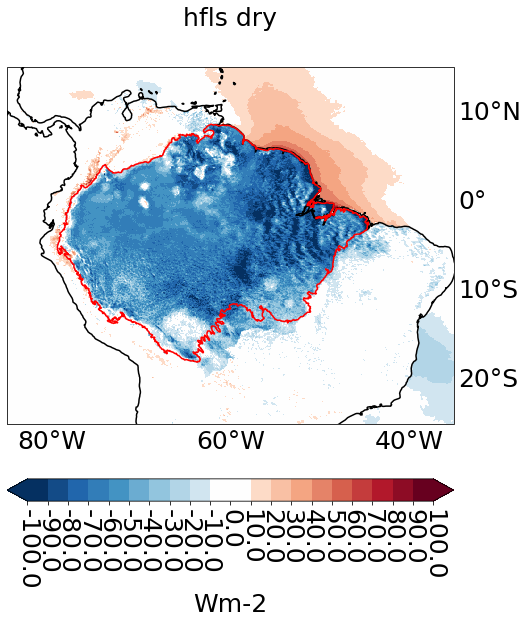

In [20]:
contourf_data(- hfls_def_month_dry + hfls_ctl_month_dry, RdBu_r_new, 'both', -100, 100, 21, 
                     -30, 20, 10, -90, -30, 10,
                     'Wm-2', 'hfls dry')

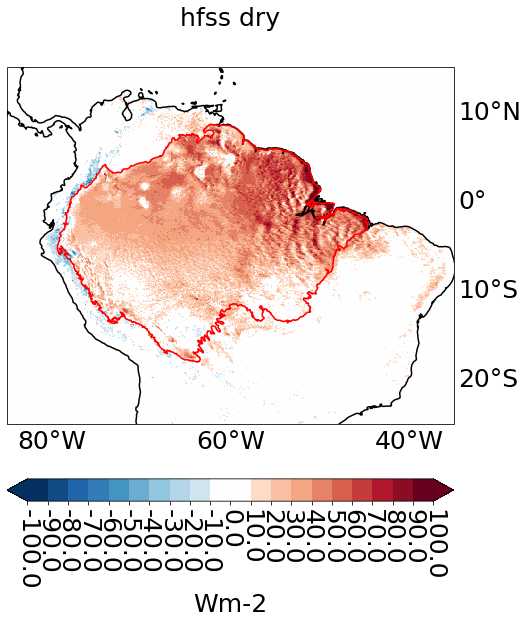

In [21]:
contourf_data(- hfss_def_month_dry + hfss_ctl_month_dry, RdBu_r_new, 'both', -100, 100, 21, 
                     -30, 20, 10, -90, -30, 10,
                     'Wm-2', 'hfss dry')

In [17]:
# Summation of the energy fluxes
conv_energy_ctl_wet = -hfls_ctl_month_wet - hfss_ctl_month_wet
conv_energy_ctl_dry = -hfls_ctl_month_dry - hfss_ctl_month_dry

conv_energy_def_wet = -hfls_def_month_wet - hfss_def_month_wet
conv_energy_def_dry = -hfls_def_month_dry - hfss_def_month_dry

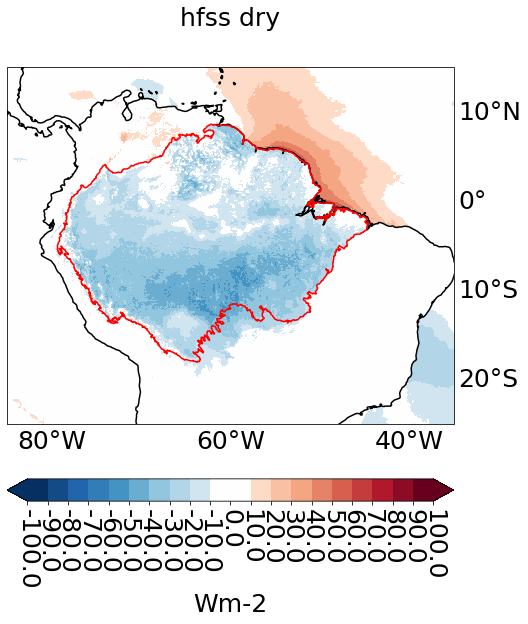

In [19]:
contourf_data(conv_energy_def_dry - conv_energy_ctl_dry, RdBu_r_new, 'both', -100, 100, 21, 
                     -30, 20, 10, -90, -30, 10,
                     'Wm-2', 'hfss dry')

## Load Specific humidity data

In [13]:
glob_pattern_ctl = 'ctl_daily_hus_'
glob_pattern_def = 'def_daily_hus_'

data_path_ctl = Path('/scratch/m/m300948/test_04/3d/hus')
data_path_def = Path('/scratch/m/m300948/def_100/3d/hus')

## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_ctl_hus = sorted([str(f) for f in data_path_ctl.rglob(f'{glob_pattern_ctl}*.nc')])[:]
file_def_hus = sorted([str(f) for f in data_path_def.rglob(f'{glob_pattern_def}*.nc')])[:]

In [14]:
times = ['2022-01-01','2022-12-31']
var_hus = 'hus'
time_mean = '1MS'

hus_ctl_land = Tools.time_mean_model(file_ctl_hus,times,time_mean,var_hus,[-60,20],[-100,-20],'trop')
hus_def_land = Tools.time_mean_model(file_def_hus,times,time_mean,var_hus,[-60,20],[-100,-20],'trop')

In [15]:
# groupby: groupping by month throughout the whole time period
hus_ctl_month = hus_ctl_land.groupby('time.month').mean('time')
hus_def_month = hus_def_land.groupby('time.month').mean('time')

In [16]:
xarray_names = ['hus_ctl_month','hus_def_month']

for name in xarray_names:
    xarray_data = globals()[name]
        
    xarray_data_wet = xarray_data.where(xarray_data.month.isin([1,2,12]), drop=True).mean("month")
    xarray_data_dry = xarray_data.where(xarray_data.month.isin([7,8,9]), drop=True).mean("month")
        
    new_name_wet = name + '_wet'
    new_name_dry = name + '_dry'
        
    globals()[new_name_wet] = xarray_data_wet
    globals()[new_name_dry] = xarray_data_dry

_mixing ratio_

In [17]:
xarray_names = ['hus_ctl_month_wet','hus_ctl_month_dry','hus_def_month_wet','hus_def_month_dry']

for name in xarray_names:
    xarray_data = globals()[name]
        
    xarray_data_mix = xarray_data / (1 - xarray_data)

    new_name_mix = name + '_mr'
        
    globals()[new_name_mix] = xarray_data_mix

## Moisture advection (equation only)

In [18]:
moadv_ctl_700_wet = - ua_ctl_month_70000_wet * Tools.x_derivative(hus_ctl_month_wet_mr.isel(plev=1)) - va_ctl_month_70000_wet * Tools.y_derivative(hus_ctl_month_wet_mr.isel(plev=1))
moadv_ctl_700_dry = - ua_ctl_month_70000_dry * Tools.x_derivative(hus_ctl_month_dry_mr.isel(plev=1)) - va_ctl_month_70000_dry * Tools.y_derivative(hus_ctl_month_dry_mr.isel(plev=1))

In [ ]:
moadv_def_1000_dry = moadv_def_1000_dry.coarsen(lon=5,lat=6).mean() 
moadv_ctl_1000_dry = moadv_ctl_1000_dry.coarsen(lon=5,lat=6).mean() 

# Plotting

In [22]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [23]:
def plot_scatter(data,inter,time,lon,lat,vmin,vmax,cmaps,extends,title='',colorbar=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
    proj = ccrs.PlateCarree()
    plot = plt.scatter(data.clon[::inter],data.clat[::inter],s=0.6,c=data[time,::inter],\
               cmap=cmaps,vmin=vmin,vmax=vmax,transform=proj) #map=plt.cm.get_cmap(cmaps, ranges[2])
    cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',shrink=0.8,pad=0.09)
    cb1.ax.set_xlabel('w / 10${-3}$ m s${-1}$)',fontsize=12)
    cb1.ax.tick_params(labelsize=12)
    #ax.set_title(title)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([lon[0],lon[1],lat[0],lat[1]], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat[0],lat[1]+0.1,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(lon[0], lon[1]+0.1,20),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

In [24]:
def contourf_data(data_gph, colormap, extend, varmin, varmax, space, 
                     lat_min, lat_max, int_lat, lon_min, lon_max, int_lon,
                     cb_title, title):
    
    ## Amazon basin contour
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    ## gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False

    ## plot data
    plot = data_gph.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
    bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_xticklabels(bounds,rotation=270)
    cb.set_label(label=cb_title, size=25)

    kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
    
    ## boundary contour
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
    ax.set_title(title, y=1.1, fontsize=25)

In [67]:
def plot_windvector(gph_true, data_gph, colormap, extend, varmin, varmax, space, 
                     dset_uas, dset_vas, q_interval, scale, width, x_place, y_place, wind_speed, color,
                     obj_1 , lati_1, loni_1, colors_1, obj_2, lati_2, loni_2, colors_2, obj_3, lati_3, loni_3, std_lat_3, std_lon_3, colors_3,
                     lat_min, lat_max, int_lat, lon_min, lon_max, int_lon,
                     cb_title, title):
    
    ## Amazon basin contour
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    ## gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False

    ## plot data
    if gph_true == True:
        plot = data_gph.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
        bounds = np.linspace(varmin,varmax, space)
        cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
        cb.ax.tick_params(labelsize=25)
        cb.ax.set_xticklabels(bounds,rotation=270)
        cb.set_label(label=cb_title, size=25)
    ## wind data
    vplot=ax.quiver(dset_uas.lon.values[::q_interval], dset_uas.lat.values[::q_interval], 
                    dset_uas.values[::q_interval,::q_interval], #.isel(time=time).ua
                    dset_vas.values[::q_interval,::q_interval], 
                    scale_units='xy',
                    scale= scale, #3.0
                    width= width,
                    angles='xy',
                    color=color,
                    transform=ccrs.PlateCarree())
    ax.quiverkey(vplot, X= x_place, Y=y_place, U= 5,
             label=r'$5 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax.set_title(title, y=1.1, fontsize=25)
    
    kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
    
    ## boundary contour
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
    
    ## plot object centroid (dots)
    if obj_1 == True:
        plt.scatter(x=loni_1, y=lati_1, transform=ccrs.PlateCarree(), color=colors_1, marker='o', s=500, edgecolors='black', linewidth=3) #colors_b[i]
        
    if obj_2 == True:
        plt.scatter(x=loni_2, y=lati_2, transform=ccrs.PlateCarree(), color=colors_2, marker='o', s=500, edgecolors='black', linewidth=3) #colors_b[i]
        
    if obj_3 == True:
        plt.errorbar(x=loni_3, y=lati_3, xerr=std_lon_3, yerr=std_lat_3, transform=ccrs.PlateCarree(), color='black') #colors_b[i]
        plt.scatter(x=loni_3, y=lati_3, transform=ccrs.PlateCarree(), color=colors_3, marker="o", s=500) #colors_g
    
    ax.set_title(title, y=1.1, fontsize=25)

In [59]:
RdBu_new = Tools.colormap_create('RdBu',21,10,11)
viridis_new = Tools.colormap_create('viridis',11,0,1)
PiYG_r_new = Tools.colormap_create('PiYG_r',21,10,11)
BrBG_new = Tools.colormap_create('BrBG',21,10,11)

In [27]:
# all, wet, dry
sam_ctl_lati = [-0.55,-4.95,3.05]
sam_ctl_loni = [-66.75,-64.55,-67.65]
sam_def_lati = [-2.25,-13.95,2.95]
sam_def_loni = [-69.25,-59.45,-69.35]
mean_imerg_lati = [0,0,0]
mean_imerg_loni = [0,0,0]
std_imerg_lati = [0,0,0]
std_imerg_loni = [0,0,0]

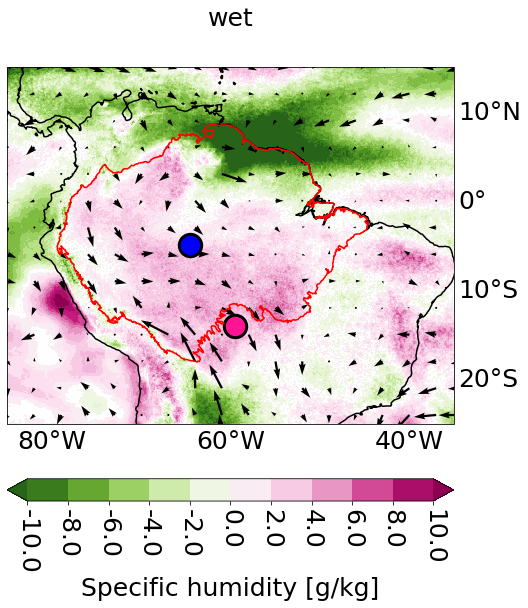

In [35]:
# Difference
plot_windvector(True,hus_def_month_wet.isel(plev=1)*10000-hus_ctl_month_wet.isel(plev=1)*10000, PiYG_r_new, 'both', -10, 10, 11, 
                    ua_def_month_70000_wet-ua_ctl_month_70000_wet, va_def_month_70000_wet-va_ctl_month_70000_wet,
                    30, 0.7, 0.005, 0.9, 0.85, 10,
                     True , sam_ctl_lati[1], sam_ctl_loni[1], 'blue', True, sam_def_lati[1], sam_def_loni[1], 'deeppink', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                      -30, 20, 10, -90, -30, 10,
                     'Specific humidity [g/kg]','wet')

_plot changes in gph_

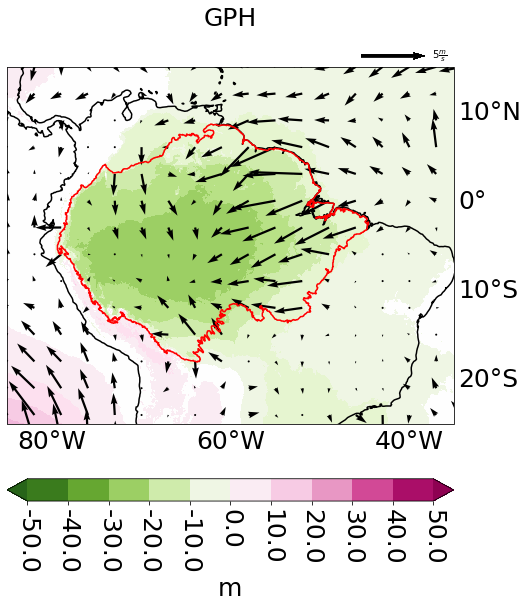

In [44]:
# lat: -60, 20, lon: -100, -20 // -30, 20, 10, -90, -30, 10,
plot_windvector(True, zg_def_month_100000_dry-zg_ctl_month_100000_dry, PiYG_r_new, 'both', -50, 50, 11, 
                    ua_def_month_100000_dry-ua_ctl_month_100000_dry, va_def_month_100000_dry-va_ctl_month_100000_dry, 
                    30, 0.7, 0.005, 0.85, 0.75, 10,
                     False , sam_ctl_lati[1], sam_ctl_loni[1], 'blue', False, sam_def_lati[1], sam_def_loni[1], 'orangered', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 10, -90, -30, 10,
                     'm','GPH')

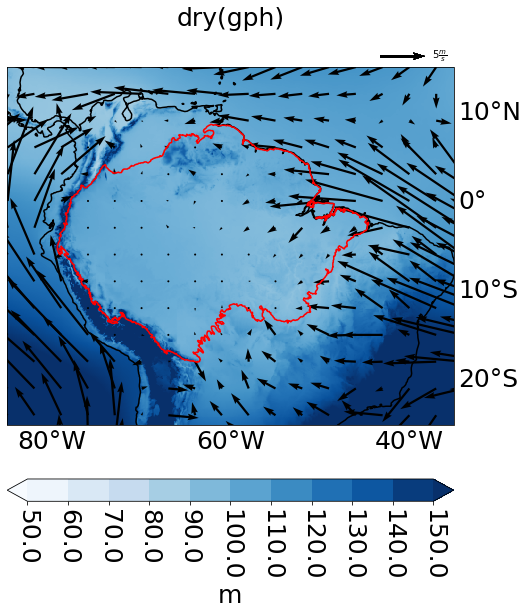

In [43]:
# lat: -60, 20, lon: -100, -20 // -30, 20, 10, -90, -30, 10,
plot_windvector(True, zg_ctl_month_100000_dry, 'Blues', 'both', 50, 150, 11, 
                    ua_ctl_month_100000_dry, va_ctl_month_100000_dry, 
                    30, 1.0, 0.005, 0.85, 0.75, 10,
                     False , sam_ctl_lati[1], sam_ctl_loni[1], 'blue', False, sam_def_lati[1], sam_def_loni[1], 'orangered', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 10, -90, -30, 10,
                     'm','dry(gph)')